# n-task Q-learning

The purpose of this notebook is to provide sample proofs-of-concept for various aspects of reinforcement learning using n-task.

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from ntask.atrs import AtrModel, AtrMovingAverage
from ntask.callbacks import AtrLogger
from ntask.layers import Context
from ntask.models import NTaskModel as NTask
from ntask.flags import Verbosity
from ntask.utils import set_seed

## n-task Model

This is an experimental extended implementation of the n-task model supporting subsequent layers without bias weights.

There are several approaches that could be used and aspects that should be taken into consideration:

- When summing up the gradients, negative deltas cancel out positive deltas, which I believe incorrectly reduces the magnitude.
- MSE of the gradients produces more accurate context deltas in general

In [110]:
class NTaskModel(NTask):
    def _calc_context_loss(self, ctx_layer_idx, gradients):
        """
        IMPORTANT: 
        1) Assumes no use of activation function on Ntask layer
        2) Assumes that the layer following the Ntask layer:
            a) Is a Dense layer
            b) Is using bias
               — ex: Dense(20, ... , use_bias=True) 
               — note Keras Dense layer uses bias by default if no value is given for use_bias param
        3) Assumes index of the next layer's gradient is known within the gradients list returned from gradient tape in a tape.gradient call
        4) If the above points aren't met, things will break and it may be hard to locate the bugs
        """
        # From the delta rule in neural network math
        if self.layers[ctx_layer_idx + 1].use_bias:
            index = self.ctx_gradient_map[ctx_layer_idx] + 1 # Simplify the calculation of the deltas
            delta_at_next_layer = gradients[index]
        else:
            index = self.ctx_gradient_map[ctx_layer_idx]
#             signs = tf.sign(tf.reduce_sum(gradients[index], axis=0))
#             delta_at_next_layer = tf.reduce_mean(tf.multiply(gradients[index], gradients[index]), axis=0)
#             delta_at_next_layer = tf.multiply(signs, tf.reduce_mean(tf.abs(gradients[index]), axis=0))
            delta_at_next_layer = tf.reduce_sum(gradients[index], axis=0)
        transpose_of_weights_at_next_layer = tf.transpose(self.layers[ctx_layer_idx + 1].weights[0])
        context_delta = tf.tensordot(delta_at_next_layer, transpose_of_weights_at_next_layer, 1)
        return context_delta

In [111]:
class Switch(AtrModel):
    pass
#     def context_loss_fn(self, context_delta):
#         return tf.keras.
    
#     def should_switch(self, epoch, context_loss):
#         pass

## Wisconsin Card Sort

In [112]:
def random_card():
    """
    Generate a one-hot encoded card.
    Returns a tuple of the card and the expected output label
    """
    x = np.identity(3)
    np.random.shuffle(x)
    return x

In [52]:
def policy(predicted, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(3), True
    return np.argmax(predicted), False

In [53]:
def reward(sort, rule):
    if sort == rule:
        return 5.0
    return -5.0

In [96]:
def wcst_episode(model, logger, rule, ep, epsilon=0.01, alpha=0.5, gamma=0.95, callbacks=[]):
    # Random card to sort
    card = random_card()
    card = card.reshape((1,) + card.shape)
    
    print(end=f"{ep}: ")
    
    # Predict and sort
    value = model.predict(card)[0]
    sort, is_random = policy(value, epsilon)
    r = reward(sort, rule)
    
    if is_random:
        print("Random action taken")
    
    # Q-learning update
    print(value, end=" => ")
    td_error = alpha*(r - value[sort])
    value[sort] += td_error
    target = value.reshape((1,) + value.shape)
    print(target)
    model.fit(card, target, train_after_switch=False, find_best_fit=False, callbacks=callbacks, verbose=Verbosity.Contexts)
    
    context_delta = list(logger.plots.values())[0][(None, 'Epoch', 'Context Delta')]["Context Delta"]['y'][-1]
    print(np.sign(context_delta) == np.sign(td_error), "Context Delta vs. TD-error:", float(context_delta), td_error)
    
    return sort == rule, is_random

In [97]:
def wisconsin_card_sort(model, logger, episodes, seq_correct=3, epsilon=0.01, alpha=0.5, gamma=0.95, callbacks=[], initial_shuffle=False, shuffle=True):
    NUM_DIMENSIONS = 3
    rule = 0 if not initial_shuffle else np.random.randint(NUM_DIMENSIONS)
    tried_all = False
    correct = 0
    print("Rule is:", rule)
    for ep in range(episodes):
        # Perform the episode. Count the sequentially correct episodes
        is_correct, is_random = wcst_episode(model, logger, rule, ep, epsilon, alpha, gamma, callbacks)
        if is_correct:
            correct += 1
        else:
            correct = 0
            
        # Change the rule once the model has learned the rule
        if correct >= seq_correct:
            correct = 0
            if shuffle and (initial_shuffle or tried_all):
                oldrule = rule
                while rule == oldrule:
                    rule = np.random.randint(NUM_DIMENSIONS)
            else:
                if rule + 1 == NUM_DIMENSIONS:
                    tried_all = True
                rule = (rule + 1) % NUM_DIMENSIONS
            print(f"\nEpisode: {ep+1}; New rule is:", rule, '\n')

### Model

In [101]:
set_seed(2)

In [102]:
# Optimizer
# optimizer = tf.keras.optimizers.SGD(1e-1)
optimizer = tf.keras.optimizers.Adam(1e-2)

# Hyperparameters
hrr_size = 64
num_contexts = 3
switch_threshold = -1.5

# Model Architecture
inp = Input((3,3))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu", use_bias=False)(x)
x = Context(num_contexts, AtrMovingAverage(switch_threshold))(x)
x = Dense(3, activation="linear", use_bias=False)(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [103]:
episodes = 50
seq_correct = 30
epsilon = 0.1
alpha = 1.0
gamma = 0.75

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

wisconsin_card_sort(model, logger, episodes, seq_correct, epsilon, alpha, gamma, callbacks)

Rule is: 0
0: Random action taken
[-0.3592347  -0.01275272 -0.35699028] => [[-0.3592347  -0.01275272 -5.        ]]
False Context Delta vs. TD-error: 0.0 -4.643009722232819
1: [-0.05000715  0.21451156 -0.32315254] => [[-0.05000715 -5.         -0.32315254]]
True Context Delta vs. TD-error: -0.017954053357243538 -5.2145115584135056
2: [-0.0405277   0.01484657 -0.38585615] => [[-0.0405277  -5.         -0.38585615]]
True Context Delta vs. TD-error: -0.005825401283800602 -5.014846569858491
3: [-0.27865526 -0.16699988  0.3656221 ] => [[-0.27865526 -0.16699988 -5.        ]]
False Context Delta vs. TD-error: 0.004963861778378487 -5.365622103214264
4: [ 0.08725923 -0.25249815 -0.25822014] => [[ 5.         -0.25249815 -0.25822014]]
True Context Delta vs. TD-error: 0.008324762806296349 4.912740774452686
5: [-0.22938381 -0.3106256   0.08568858] => [[-0.22938381 -0.3106256  -5.        ]]
False Context Delta vs. TD-error: 0.0005285954102873802 -5.085688583552837
6: [ 0.16855435 -0.4242655  -0.6251976

In [80]:
list(logger.plots.values())[0][(None, 'Epoch', 'Context Delta')]["Context Delta"]['y'][-1]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.017954053>

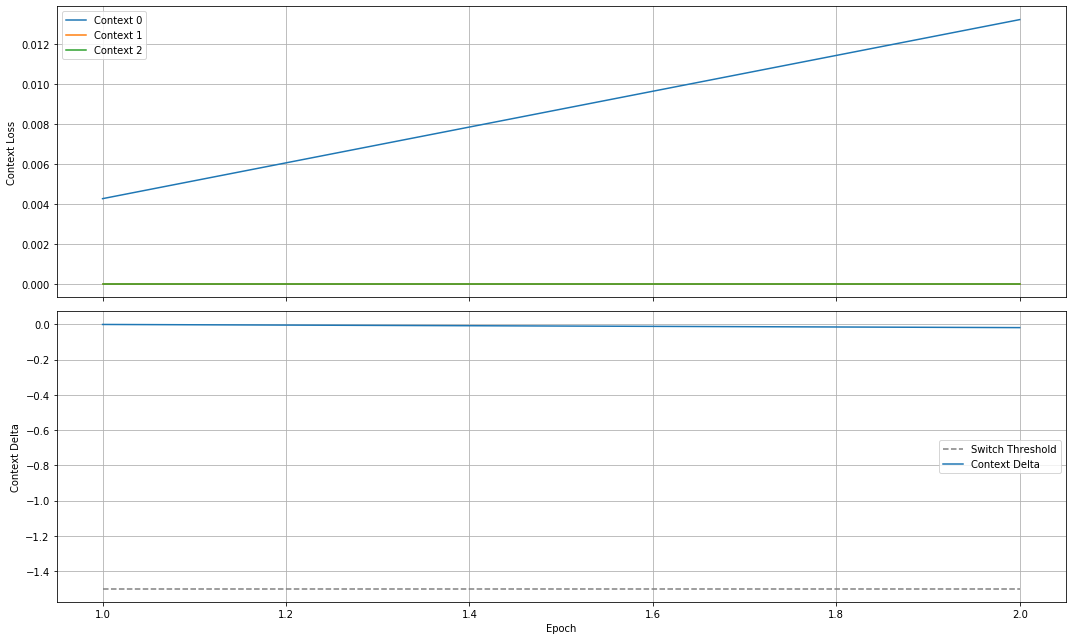

In [75]:
logger.plot(figsize=(15,9))